In [ ]:
# Note: You can select between running the Notebook on "CPU" or "GPU"
# Click "Runtime > Change Runtime time" and set "GPU"

In [ ]:
#Uncomment to install ydata-synthetic lib
! pip install ydata-synthetic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 5.0 MB/s 
     |████████████████████████████████| 394.5 MB 42 kB/s 
     |████████████████████████████████| 14.8 MB 56.1 MB/s 
     |████████████████████████████████| 11.6 MB 59.8 MB/s 
     |████████████████████████████████| 280 kB 66.7 MB/s 
     |████████████████████████████████| 9.9 MB 47.8 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
     |████████████████████████████████| 596 kB 70.5 MB/s 
     |████████████████████████████████| 462 kB 69.8 MB/s 
     |████████████████████████████████| 132 kB 70.9 MB/s 
     |████████████████████████████████| 3.8 MB 67.4 MB/s 
     |████████████████████████████████| 2.9 MB 43.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68714 sha256=1e09e9b780287f66b84c9b51da5cafdcf2cf4bd2bdbb025fa0e31ef30c0a3e87
  Stored in directory: /root/.cache/pip/wheels/

# Time Series synthetic data generation with TimeGAN

- TimeGAN - Implemented accordingly with the [paper](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks)
- This notebook is an example of how TimeGan can be used to generate synthetic time-series data.

## Dataset and imports

- The data used in this notebook was downloaded from [Yahoo finance](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) and includes:
    - **6 variables** - Open, High, Low, Close, Adj Close, Volume
    - **1022 events** registered between the period of 1 January 2017 - 24 January 2021.
    - The data was processed using a MinMaxScaler (all the variables were numeric)

In [ ]:
#Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC


## Define Model hyperparameters

**Networks:**
- Generator
- Discriminator
- Embedder
- Recovery Network

TimeGAN is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.

Similarly to other parameters, the architectures of each element should be optimized and tailored to the data.

In [ ]:
#Specific to TimeGANs
seq_len=24
n_seq = 6
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

## The data

In [ ]:
stock_data = processed_stock(path='/content/drive/MyDrive/test/dataset/energy_data_1100.csv', seq_len=seq_len)
print(len(stock_data),stock_data[0].shape)

1075 (24, 6)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Training the TimeGAN synthetizer

In [ ]:
if path.exists('synthesizer_stock.csv'):
    synth = TimeGAN.load('synthesizer_stock.csv')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(stock_data, train_steps=20000)
    synth.save('synthesizer_stock.csv')

### The generated synthetic stock data

In [ ]:
synth_data = synth.sample(len(stock_data))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s]

(1152, 24, 6)


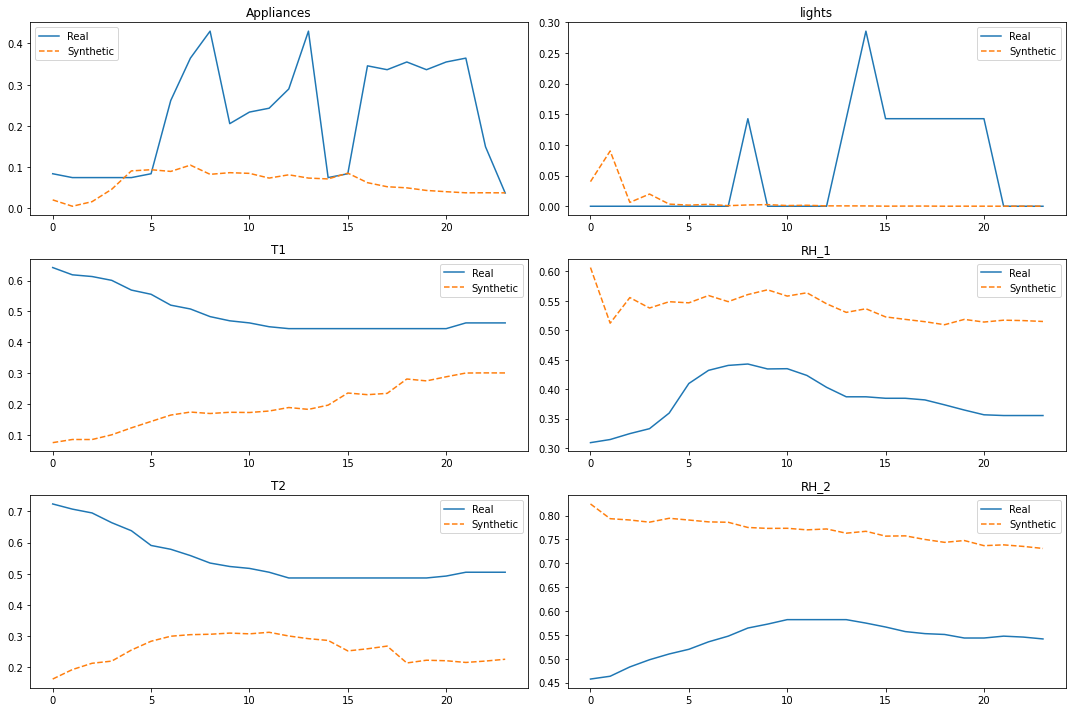

In [ ]:
#Reshaping the data
cols = ["Appliances", "lights", "T1", "RH_1", "T2", "RH_2"]

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(stock_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

#### Evaluation of the generated synthetic data (PCA and TSNE)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

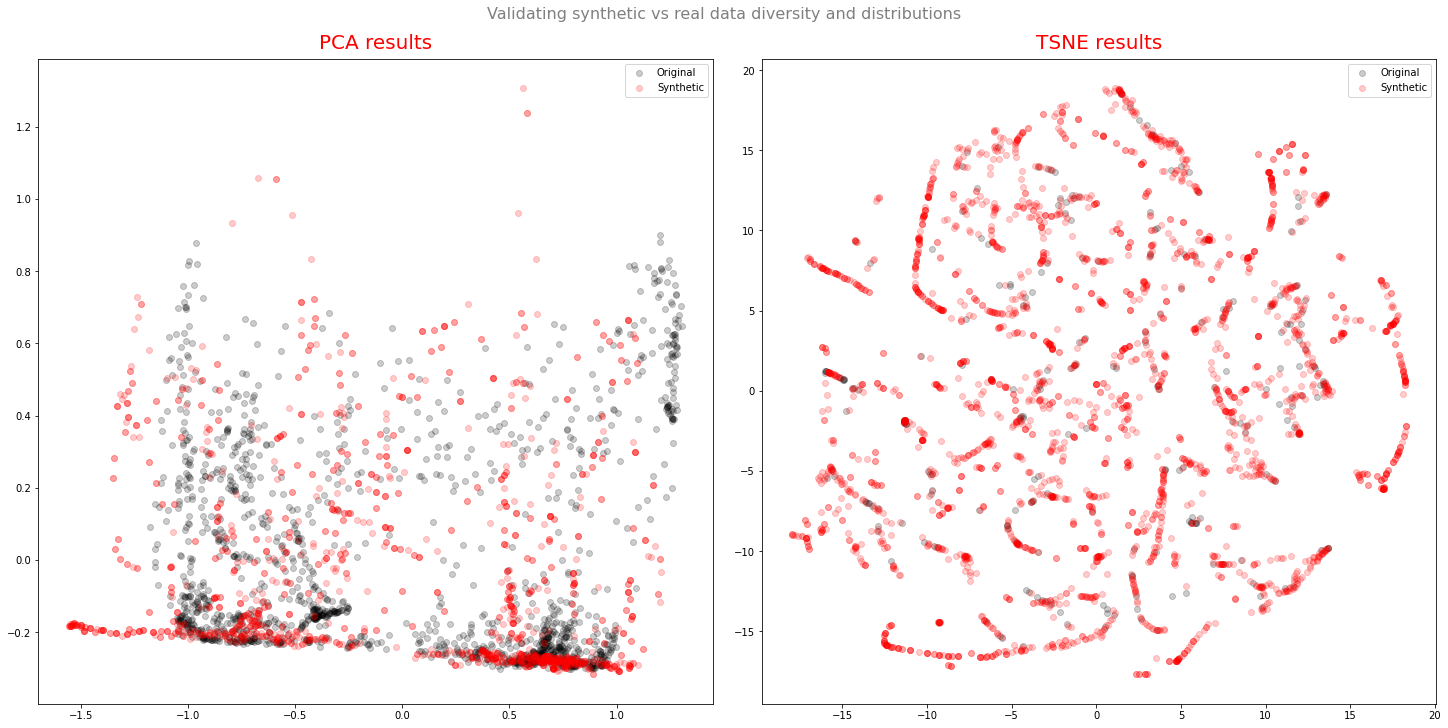

In [ ]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

#### Train synthetic test real (TSTR)

In [ ]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import AUC

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    metrics=[AUC(name='AUC'), 'accuracy']
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=6,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model

In [ ]:
#Prepare the dataset for the regression model
stock_data=np.asarray(stock_data)
synth_data = synth_data[:len(stock_data)]
n_events = len(stock_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (806, 23, 6)
Real X train: (806, 23, 6)
Synthetic y train: (806, 6)
Real y train: (806, 6)
Real X test: (269, 23, 6)
Real y test: (269, 6)


In [ ]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
7/7 [==============================] - 2s 111ms/step - loss: 0.2606 - AUC: 0.3568 - accuracy: 0.3493 - val_loss: 0.2524 - val_AUC: 0.3171 - val_accuracy: 0.3197
Epoch 2/200
7/7 [==============================] - 0s 53ms/step - loss: 0.2507 - AUC: 0.3446 - accuracy: 0.3542 - val_loss: 0.2415 - val_AUC: 0.3390 - val_accuracy: 0.3346
Epoch 3/200
7/7 [==============================] - 0s 50ms/step - loss: 0.2355 - AUC: 0.4093 - accuracy: 0.3802 - val_loss: 0.2310 - val_AUC: 0.4521 - val_accuracy: 0.5019
Epoch 4/200
7/7 [==============================] - 0s 54ms/step - loss: 0.2270 - AUC: 0.4825 - accuracy: 0.6727 - val_loss: 0.2207 - val_AUC: 0.4651 - val_accuracy: 0.7807
Epoch 5/200
7/7 [==============================] - 0s 51ms/step - loss: 0.2164 - AUC: 0.4827 - accuracy: 0.7511 - val_loss: 0.2110 - val_AUC: 0.4674 - val_accuracy: 0.5874
Epoch 6/200
7/7 [==============================] - 0s 50ms/step - loss: 0.2069 - AUC: 0.4847 - accuracy: 0.5856 - val_loss: 0.2022 - val_AU

In [ ]:
history = pd.DataFrame(real_train.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          106 non-null    float64
 1   AUC           106 non-null    float64
 2   accuracy      106 non-null    float64
 3   val_loss      106 non-null    float64
 4   val_AUC       106 non-null    float64
 5   val_accuracy  106 non-null    float64
dtypes: float64(6)
memory usage: 5.1 KB


In [ ]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
7/7 [==============================] - 2s 107ms/step - loss: 0.2491 - AUC: 0.0000e+00 - accuracy: 0.1768 - val_loss: 0.2466 - val_AUC: 0.6102 - val_accuracy: 0.4424
Epoch 2/200
7/7 [==============================] - 0s 54ms/step - loss: 0.2384 - AUC: 0.0000e+00 - accuracy: 0.3971 - val_loss: 0.2377 - val_AUC: 0.7258 - val_accuracy: 0.5502
Epoch 3/200
7/7 [==============================] - 0s 52ms/step - loss: 0.2257 - AUC: 0.0000e+00 - accuracy: 0.4371 - val_loss: 0.2284 - val_AUC: 0.7817 - val_accuracy: 0.5688
Epoch 4/200
7/7 [==============================] - 0s 56ms/step - loss: 0.2161 - AUC: 0.0000e+00 - accuracy: 0.6025 - val_loss: 0.2189 - val_AUC: 0.7820 - val_accuracy: 0.5688
Epoch 5/200
7/7 [==============================] - 0s 48ms/step - loss: 0.2052 - AUC: 0.0000e+00 - accuracy: 0.5931 - val_loss: 0.2093 - val_AUC: 0.7899 - val_accuracy: 0.5688
Epoch 6/200
7/7 [==============================] - 0s 52ms/step - loss: 0.1944 - AUC: 0.0000e+00 - accuracy: 0.6067 - v

In [ ]:
history = pd.DataFrame(synth_train.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          43 non-null     float64
 1   AUC           43 non-null     float64
 2   accuracy      43 non-null     float64
 3   val_loss      43 non-null     float64
 4   val_AUC       43 non-null     float64
 5   val_accuracy  43 non-null     float64
dtypes: float64(6)
memory usage: 2.1 KB


In [ ]:
from matplotlib.ticker import FuncFormatter
import seaborn as sns

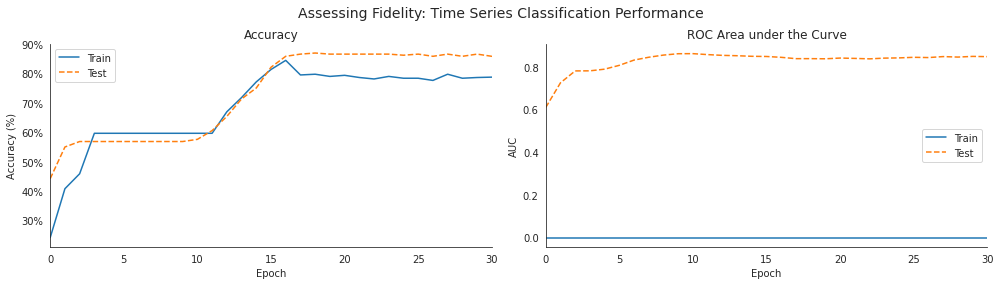

In [ ]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 30))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 30))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

In [ ]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error, mean_squared_error, mean_absolute_percentage_error
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

metrics_dict = {'r2': [r2_score(y_stock_test, real_predictions),
                       r2_score(y_stock_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_stock_test, real_predictions),
                        mean_absolute_error(y_stock_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_stock_test, real_predictions),
                         mean_squared_log_error(y_stock_test, synth_predictions)],
                'MSE': [mean_squared_error(y_stock_test, real_predictions),
                         mean_squared_error(y_stock_test, synth_predictions)],
                'MAPE': [mean_absolute_percentage_error(y_stock_test, real_predictions),
                         mean_absolute_percentage_error(y_stock_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

,r2,MAE,MRLE,MSE,MAPE
Real,0.616813,0.048024,0.004796,0.007723,2.309093e+13
Synthetic,0.429638,0.078489,0.007573,0.013011,3.359485e+13
